# Comparing journey times returned by Mapzen's OSRM and [Valhalla](https://mapzen.com/projects/valhalla) instances, and the Google Maps Directions API

If you'd like to run this analysis locally, install the packages from `requirements.txt`

In [52]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib as mpl
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import json
from itertools import chain
import requests
from shapely.geometry import mapping, Point, Polygon, LineString, MultiLineString, MultiPolygon, box
from geojson import Feature, FeatureCollection, LineString as gj_ls, MultiLineString as gj_ml, dumps as gj_dumps
from shapely.ops import unary_union
import fiona
from descartes import PolygonPatch

import statsmodels
import statsmodels.formula.api as sm

from IPython.html import widgets
from IPython.html.widgets import interact
from IPython.display import display


from helpers import query_route_osrm, query_route_valhalla, query_route_gmaps, decode_polyline, project_linestring
from IPython.core.display import HTML
%matplotlib inline
mpl.rcParams['figure.figsize'] = (16, 12)

Skip the next cell if you don't want font customisation

In [2]:
from matplotlib import rc
rc('font', **{'family':'sans-serif',
    'sans-serif':['Helvetica'],
    'monospace': ['Inconsolata'],
    'serif': ['Adobe Garamamond Pro']})

Skip the next cell if you don't have LaTeX installed

In [3]:
rc('text', **{'usetex': True})
rc('text', **{'latex.preamble': '\usepackage{sfmath}'})

The journey times were retrieved by calling Mapzen's [OSRM](https://github.com/urschrei/Geopython/blob/6b504b857a736c3b011755ce44821cefdefd70bf/isochrone.ipynb) and [Valhalla](https://github.com/urschrei/Geopython/blob/master/isochrone.ipynb) instances, respectively, and by calling the Google Maps [Directions API](https://console.developers.google.com/project/london-bikeshare-routes/apiui/apiview/directions_backend/usage).  

Journeys were calculated from the *approximate* London Bike Share network centroid, on Westminster Bridge, to each station in the network.  
Calls to OSRM used `viaroute=bicycle`, calls to Valhalla used `{costing: bicycle}`  
No costing options were set for Valhalla or Google Maps.  

The journey times were retrieved from `['route_summary']['total_time']` for OSRM  
The journey times were retrieved from `['trip']['summary']['time']` for Valhalla  
The journey times were retrieved by summing the `duration` value for each step in each leg from `route[0]` for Google Maps.

In [47]:
osrm_station_data = pd.read_csv('stations_travel_time.csv', index_col=0)
valhalla_station_data = pd.read_csv('stations_travel_time_valhalla.csv', index_col=0)

# what do they look like, how long are they?
print(osrm_station_data.columns, len(osrm_station_data))
print(valhalla_station_data.columns, len(valhalla_station_data))

(Index([u'lat', u'lon', u'name', u'projected_lon', u'projected_lat',
       u'centroid_distance', u'travel_time'],
      dtype='object'), 567)
(Index([u'lat', u'lon', u'name', u'projected_lon', u'projected_lat',
       u'centroid_distance', u'travel_time'],
      dtype='object'), 733)


####Journey origin is:

-0.12203999999842599, 51.500829999995766 (lon, lat)  
27054.81221603953, 25108.754540393566 (projected coordinates)  

`centroid_distance` is calculated using pythagoras' theorem  
`travel_time` is calculated in minutes (returned journey time / 60)

Since Valhalla returned more valid journeys than OSRM, we'll use a left join to keep only those common to both 

In [48]:
merged = pd.merge(
    osrm_station_data,
    valhalla_station_data[['name', 'travel_time']],
    how='left',
    on=['name'],
    suffixes=['_osrm', '_valhalla']).dropna()

# get GMaps data
merged = pd.merge(
    merged,
    pd.read_csv('gmaps_journeys.csv'),
    how='left',
    on=['name'],
    suffixes=['_osrm', '_valhalla']).dropna()

# 0 travel time makes no sense; make it 1 minute
merged.loc[merged['travel_time_osrm'] <= 0., 'travel_time_osrm'] = 0.

In [6]:
merged.head()

,lat,lon,name,projected_lon,projected_lat,centroid_distance,travel_time_osrm,travel_time_valhalla,Unnamed: 0,travel_time_gmaps,gmaps_route
0,51.529163,-0.109971,"River Street , Clerkenwell",27811.388447,28282.270369,2968.313250,22.293144,17.133333,0,20.666667,ewiyHxyVsMmA{JmAmMuBUHq@lAGZtBxAGR@BFFCJgBsA{B...
1,51.499607,-0.197574,"Phillimore Gardens, Kensington",21813.727944,24840.827966,3969.751444,32.789598,17.333333,1,31.283333,ewiyHxyVsMmA{JmAmMuBUHq@lAGZtBxAFD~BpBNJGRWnB]...
2,51.521284,-0.084606,"Christopher Street, Liverpool Street",29594.342661,27451.475186,4503.092527,23.073286,19.300000,2,22.183333,ewiyHxyVsMmA{JmAmMuBUHq@lAGZtBxAGR@BFFCJgBsA{B...
3,51.530059,-0.120974,"St. Chad's Street, King's Cross",27045.344113,28362.269051,2336.626317,24.231678,16.233333,3,22.550000,ewiyHxyVsMmA{JmAmMuBUHq@lAGZtBxAGR@BFFCJgBsA{B...
4,51.493130,-0.156876,"Sedding Street, Sloane Square",24657.683764,24190.679446,2899.434664,15.366430,10.950000,4,19.800000,ewiyHxyVt_@rDjJlAfBp@vFbE^\tAjCDHBNCHE@CH@D|Dv...


Cluster journeys using k-means++

In [49]:
kmeans_osrm = KMeans(init='k-means++', n_clusters=7, n_init=10)
kmeans_osrm.fit(merged[['centroid_distance', 'travel_time_osrm']])
merged['kmeans_bin_osrm'] = kmeans_osrm.labels_
kmeans_centroids_osrm = kmeans_osrm.cluster_centers_

kmeans_valhalla = KMeans(init='k-means++', n_clusters=7, n_init=10)
kmeans_valhalla.fit(merged[['centroid_distance', 'travel_time_valhalla']])
merged['kmeans_bin_valhalla'] = kmeans_valhalla.labels_
kmeans_centroids_valhalla = kmeans_valhalla.cluster_centers_

kmeans_gmaps = KMeans(init='k-means++', n_clusters=7, n_init=10)
kmeans_gmaps.fit(merged[['centroid_distance', 'travel_time_gmaps']])
merged['kmeans_bin_gmaps'] = kmeans_gmaps.labels_
kmeans_centroids_gmaps = kmeans_gmaps.cluster_centers_

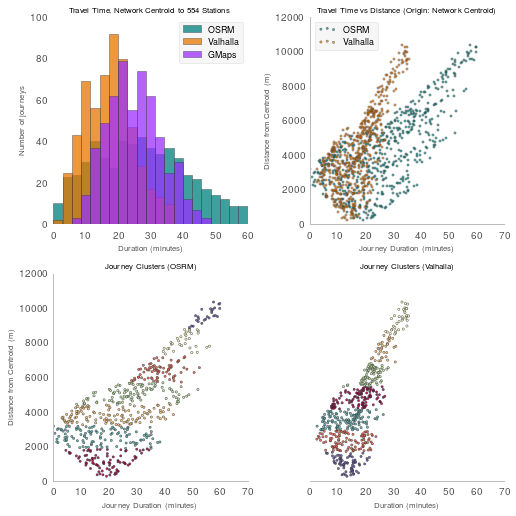

In [53]:
# set up plots
# numrows, numcolumns, plot number (specify in row, column order)
dotsize = 5.
linewidth = .5
fontsize=8

plt.clf()
fig = plt.figure(figsize=(7.28, 7.28))

# Left-hand plot
ax = fig.add_subplot(221, axisbg='none', frame_on=False)
hist = merged[['travel_time_osrm', 'travel_time_valhalla', 'travel_time_gmaps']].plot(
    ax=ax,
    kind='hist',
    color=["#008080", "#E87600", "#9B30FF"],
    edgecolor='#333333',
    bins=21,
    alpha=0.75)

plt.title(
    "Travel Time, Network Centroid to %s Stations" % len(merged),
    fontsize=8
)

ax.set_xlabel('Duration (minutes)', fontsize=fontsize)
ax.set_ylabel('Number of journeys', fontsize=fontsize)
leg = ax.legend(['OSRM', 'Valhalla', 'GMaps'], fontsize=9)
leg.get_frame().set_alpha(0.5)
ax.grid(b=False)

# Right-hand plot
ax2 = fig.add_subplot(222, axisbg='none')

osrm = plt.scatter(
    x=merged['travel_time_osrm'],
    y=merged['centroid_distance'],
    marker='o',
    color="#008080",
    edgecolor='#333333',
    lw=linewidth,
    s=dotsize,
    alpha=0.65)

valhalla = plt.scatter(
    x=merged['travel_time_valhalla'],
    y=merged['centroid_distance'],
    marker='o',
    color="#E87600",
    edgecolor='#333333',
    lw=linewidth,
    s=dotsize,
    alpha=0.65)

leg = plt.legend(
    (osrm, valhalla),
    ('OSRM',
    'Valhalla',
    'GMaps'),
    scatterpoints=3,
    fontsize=9,
    loc='upper left')
leg.get_frame().set_alpha(0.5)

plt.title(
    "Travel Time vs Distance (Origin: Network Centroid)",
    fontsize=8
)

ax2.set_xlabel('Journey Duration (minutes)', fontsize=fontsize)
ax2.set_ylabel('Distance from Centroid (m)', fontsize=fontsize)
ax2.grid(b=False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlim(0, 70)
ax2.set_ylim(0, 12000)

# Bottom left-hand plot
ax3 = fig.add_subplot(223, axisbg='none', frame_on=True)

osrm_cluster = plt.scatter(
    x=merged['travel_time_osrm'],
    y=merged['centroid_distance'],
    c=merged['kmeans_bin_osrm'],
    marker='o',
    color="#ff8300",
    cmap='Spectral',
    edgecolor='#333333',
    lw=linewidth,
    s=dotsize,
    alpha=0.85)

plt.title(
    "Journey Clusters (OSRM)",
    fontsize=8
)

ax3.set_xlabel('Journey Duration (minutes)', fontsize=fontsize)
ax3.set_ylabel('Distance from Centroid (m)', fontsize=fontsize)
ax3.grid(b=False)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.set_xlim(0, 70)
ax3.set_ylim(0, 12000)

# Bottom right-hand plot
ax4 = fig.add_subplot(224, axisbg='none', frame_on=True)

valhalla_cluster = plt.scatter(
    x=merged['travel_time_valhalla'],
    y=merged['centroid_distance'],
    c=merged['kmeans_bin_valhalla'],
    marker='o',
    color="#ff8300",
    cmap='Spectral',
    edgecolor='#333333',
    lw=linewidth,
    s=dotsize,
    alpha=0.85)

ax4.set_xlim(0, 70)
ax4.set_ylim(0, 12000)
plt.title(
    "Journey Clusters (Valhalla)",
    fontsize=8
)

ax4.set_xlabel('Duration (minutes)', fontsize=fontsize)
# ax4.set_ylabel('Distance (m)', fontsize=fontsize)
ax4.set_yticklabels([])
ax4.grid(b=False)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['left'].set_visible(False)

# Save etc
plt.tight_layout()
plt.savefig(
    'combined.png',
    format="png",
    bbox_inches='tight',
    alpha=True,
    transparent=True,
    dpi=300)

plt.show()

As is obvious from the histogram and plot, the journey times and their distribution vary significantly between the three routers; Valhalla thinks you can get to any station in just over 35 minutes, with the majority taking 15–20 minutes. OSRM's journey times are far more evenly distributed, and greater in duration. [Most](https://twitter.com/mapzen/status/626080158890479620) (though [not all](https://twitter.com/mapzen/status/626083924192690176)) of the variation in duration is explained by Valhalla's default cycle speed of **25kph**, versus OSRM's **15kph**. When cycling speed and other costing options become available in the API, it'll be much easier to make more nuanced comparisons.  
The clustering operations aren't particularly informative, but they do indicate that none of the routes are clustered in an obvious way.

## Visualising Differences in Route Geography

As a final (perhaps…) step, we're going to visualise the different routes returned by Valhalla and OSRM. In order to do this, we're going to retrieve routes from the network centroid to each station for each router, decode the polyline-encoded string, collect these, and map them.

We'll need the `Basemap` matplotlib extension in order create these static maps.

In [51]:
# define some wrappers for route retrieval
api_key = "my api key"
gmaps_key = "my api key"

def route_valhalla(df, start):
    """ return travel times between a given centroid and all stations in the network """
    return query_route_valhalla(api_key, start, (df['lon'], df['lat']), 'bicycle')

def route_osrm(df, start):
    """ return travel times between a given centroid and all stations in the network """
    return query_route_osrm(start, (df['lon'], df['lat']), 'bicycle')

# wrapper 
def route_gmaps(df, start):
    return query_route_gmaps(start, (df['lon'], df['lat']), "bicycling", gmaps_key)

Get Valhalla routes, and dump to CSV

In [ ]:
# merged['valhalla_route'] = merged.apply(
#     route_valhalla, args=((-0.12203999999842599, 51.500829999995766),), axis=1)

# merged[['name', 'valhalla_route']].to_csv('valhalla_routes.csv')

Get OSRM routes, and dump to CSV

In [21]:
# merged['osrm_route'] = merged.apply(
#     route_osrm, args=((-0.12203999999842599, 51.500829999995766),), axis=1)

# merged[['name', 'osrm_route']].to_csv('osrm_routes.csv')

Get GMaps routes, and dump to CSV

In [ ]:
# merged['gmaps_route'], merged['gmaps_travel_time'] = zip(*merged.apply(
#     route_gmaps, args=((-0.12203999999842599, 51.500829999995766)), axis=1))

# merged[['name', 'gmaps_route', gmaps_travel_time]].to_csv('gmaps_routes.csv')

In [54]:
# load and merge OSRM and valhalla routes
valhalla_routes = pd.read_csv('valhalla_routes.csv', index_col=0)
osrm_routes = pd.read_csv('osrm_routes.csv', index_col=0)

# we can't currently find a route to Paddington Green Police Station (iloc 298)
# merged[merged['valhalla_route'].isnull()]
merged = pd.merge(
    merged,
    valhalla_routes[['name', 'valhalla_route']],
    how='left',
    on=['name']).dropna()

merged = pd.merge(
    merged,
    osrm_routes[['name', 'osrm_route']],
    how='left',
    on=['name']).dropna()

# no need to do the same for GMaps, as it's in the initial merges

In [55]:
merged['valhalla_decoded'] = merged.apply(lambda f: decode_polyline(f['valhalla_route']), axis=1)
merged['osrm_decoded'] = merged.apply(lambda f: decode_polyline(f['osrm_route']), axis=1)
merged['gmaps_decoded'] = merged.apply(lambda f: decode_polyline(f['gmaps_route'], gmaps=True), axis=1)

Now set up a map, and project our routes into map coordinates

In [11]:
bds = MultiLineString(list(merged['valhalla_decoded'])).bounds
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]

In [12]:
m = Basemap(
    projection='tmerc',
    lon_0 = -0.12203999999842599,
    lat_0 = 51.500829999995766,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - extra + 0.01 * h,
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + extra + 0.01 * h,
    resolution='i',
    suppress_ticks=True)

In [63]:
# create projected version of routes
merged['valhalla_decoded_proj'] = merged.apply(lambda f: project_linestring(f['valhalla_decoded'], m), axis=1)
merged['osrm_decoded_proj'] = merged.apply(lambda f: project_linestring(f['osrm_decoded'], m), axis=1)
merged['gmaps_decoded_proj'] = merged.apply(lambda f: project_linestring(f['gmaps_decoded'], m), axis=1)

# combine projected route LineStrings
combined_valhalla = MultiLineString(list(merged['valhalla_decoded_proj']))
combined_osrm = MultiLineString(list(merged['osrm_decoded_proj']))
combined_gmaps = MultiLineString(list(merged['gmaps_decoded']))

# we can also calculate the projected route distances (as opposed to euclidian distance, as above)
merged['valhalla_route_length_proj'] = merged.apply(lambda f: f['valhalla_decoded_proj'].length, axis=1)
merged['osrm_route_length_proj'] = merged.apply(lambda f: f['osrm_decoded_proj'].length, axis=1)
merged['gmaps_route_length_proj'] = merged.apply(lambda f: f['gmaps_decoded_proj'].length, axis=1)

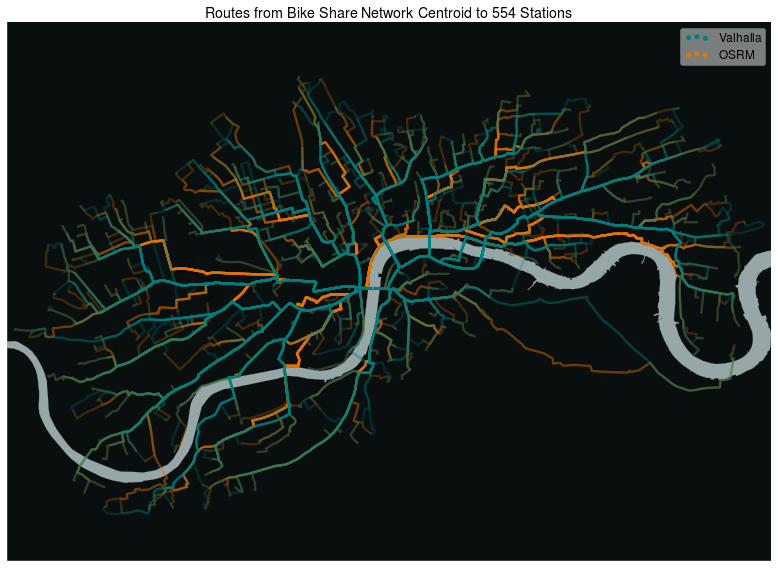

In [66]:
plt.clf()
fig = plt.figure(figsize=(12, 8), dpi=300)
ax = fig.add_subplot(111, axisbg='w', frame_on=False)


m.fillcontinents('#090F0F')
m.drawparallels(
    np.arange(ll[0], ur[0], 2.),
    color = 'black', linewidth = 0.5,
    labels=[True, False, False, False], ax=ax)
m.drawmeridians(
    np.arange(ll[1], ur[1], 2.),
    color = 'black', linewidth = 0.5,
    labels=[False, False, False, True], ax=ax)

pc_valhalla = PatchCollection([PolygonPatch(
    line.buffer(25)) for line in combined_valhalla],
    match_original=False, alpha=.25, color="#008080", lw=.01, zorder=4)
pc_valhalla.set_label("valhalla")

pc_osrm = PatchCollection([PolygonPatch(
    line.buffer(25)) for line in combined_osrm],
    match_original=False, alpha=.25, color="#E87600", lw=.01, zorder=4)
pc_osrm.set_label("osrm")


# pc_gmaps = PatchCollection([PolygonPatch(
#     line.buffer(25)) for line in combined_gmaps],
#     match_original=False, alpha=.25, color="#9B30FF", lw=.01, zorder=4)
# pc_gmaps.set_label("gmaps")

# ax.add_collection(pc_valhalla)
# ax.add_collection(pc_osrm)
# ax.add_collection(pc_gmaps)

# cascade Thames polygons together, and plot
thames = m.readshapefile(
    '../xmltocsv/data/thames_wgs84',
    'thames',
    color='none',
    zorder=4)
thames_poly = unary_union([Polygon(xy) for xy in m.thames])
tp = PatchCollection(
    [PolygonPatch(poly) for poly in thames_poly],
    match_original=False,
    color='#97a7a7', lw=.25, alpha=1., zorder=3)
ax.add_collection(tp)

# add centroid
centroid = m(-0.12204, 51.50083)
m.scatter(*centroid,
    s=5., edgecolor='#000000', alpha=1.,
    color='w', zorder=5)

# fake a legend. Tsk
lt = m.scatter([], [], color="#008080")
lo = m.scatter([], [], color="#E87600")
lg = m.scatter([], [], color="#9B30FF")

labels = ["Valhalla", "OSRM", "Google Maps"]
leg = plt.legend([lt, lo], labels)
leg.get_frame().set_alpha(0.5)

plt.title("Routes from Bike Share Network Centroid to %s Stations" % len(merged))
plt.tight_layout()
# fig.set_size_inches(7.28, 5.25)
plt.savefig('routes.png', dpi=300, bbox_inches='tight', alpha=True, transparent=True)

# convenience functions for adding and removing PatchCollections 
def remove_patches(ax, label):
    """ find and remove a PatchCollection by name """
    for idx, pc in enumerate(ax.collections):
        if pc.get_label() == label:
            ax.collections.pop(idx)

def display_valhalla(Valhalla):
    """ Display or remove Valhalla layer according to boolean input """
    if Valhalla:
        ax.add_collection(pc_valhalla)
    else:
        remove_patches(ax, "valhalla")
    display(fig)

def display_osrm(OSRM):
    """ Display or remove OSRM layer according to boolean input """
    if OSRM:
        ax.add_collection(pc_osrm)
    else:
        remove_patches(ax, "osrm")
    display(fig)
    
def display_gmaps(gmaps):
    """ Display or remove GMaps layer according to boolean input """
    if gmaps:
        ax.add_collection(pc_gmaps)
    else:
        remove_patches(ax, "gmaps")
    display(fig)

plt.close(fig)
interact(display_valhalla, Valhalla=True)
interact(display_osrm, OSRM=True)
# interact(display_gmaps, gmaps=True)
plt.show()

Let's carry out some regressions in order to determine time/distance correlation

In [58]:
# OSRM regression
osrm_res = sm.ols(
    formula='osrm_route_length_proj ~ travel_time_osrm',
    data=merged).fit()

osrm_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     osrm_route_length_proj   R-squared:                       0.997
Model:                                OLS   Adj. R-squared:                  0.997
Method:                     Least Squares   F-statistic:                 1.997e+05
Date:                    Fri, 07 Aug 2015   Prob (F-statistic):               0.00
Time:                            16:19:58   Log-Likelihood:                -3442.8
No. Observations:                     554   AIC:                             6890.
Df Residuals:                         552   BIC:                             6898.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept          486.9832     11.098     43.881      0.000       465.184   508.782
travel_time_osrm   162.9204      0.365    446.883      0.000       162.204   163.637
==============================================================================
Omnibus:                       39.578   Durbin-Watson:                   1.846
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.144
Skew:                          -0.644   Prob(JB):                     5.79e-11
Kurtosis:                       3.620   Cond. No.                         65.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
# Valhalla regression
valhalla_res = sm.ols(
    formula='valhalla_route_length_proj ~ travel_time_valhalla',
    data=merged).fit()

valhalla_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     valhalla_route_length_proj   R-squared:                       0.954
Model:                                    OLS   Adj. R-squared:                  0.954
Method:                         Least Squares   F-statistic:                 1.157e+04
Date:                        Fri, 07 Aug 2015   Prob (F-statistic):               0.00
Time:                                15:26:10   Log-Likelihood:                -4208.1
No. Observations:                         554   AIC:                             8420.
Df Residuals:                             552   BIC:                             8429.
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept             -275.1564     53.059     -5.186      0.000      -379.379  -170.934
travel_time_valhalla   303.1891      2.818    107.585      0.000       297.654   308.725
==============================================================================
Omnibus:                       27.682   Durbin-Watson:                   1.756
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.486
Skew:                          -0.465   Prob(JB):                     3.25e-08
Kurtosis:                       3.792   Cond. No.                         48.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
# GMaps regression
gmaps_res = sm.ols(
    formula='gmaps_route_length_proj ~ travel_time_gmaps',
    data=merged).fit()

gmaps_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     gmaps_route_length_proj   R-squared:                       0.932
Model:                                 OLS   Adj. R-squared:                  0.932
Method:                      Least Squares   F-statistic:                     7617.
Date:                     Fri, 07 Aug 2015   Prob (F-statistic):               0.00
Time:                             15:26:11   Log-Likelihood:                -4318.0
No. Observations:                      554   AIC:                             8640.
Df Residuals:                          552   BIC:                             8649.
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept         -1001.7058     80.238    -12.484      0.000     -1159.314  -844.097
travel_time_gmaps   266.5968      3.055     87.276      0.000       260.597   272.597
==============================================================================
Omnibus:                       36.910   Durbin-Watson:                   1.240
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.610
Skew:                           0.668   Prob(JB):                     5.59e-10
Kurtosis:                       2.757   Cond. No.                         84.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The OSRM journeys look almost perfectly correlated, whereas the Valhalla journeys don't.

WHAT IS GOING ON WITH GOOGLE MAPS THOUGH

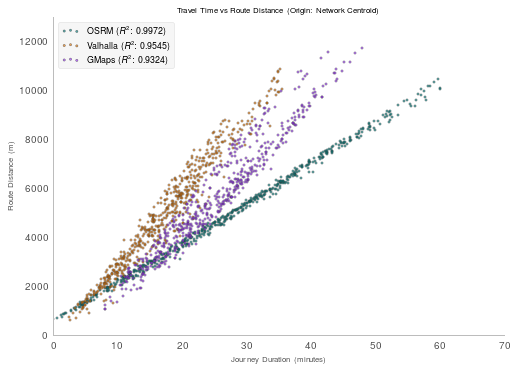

In [69]:
plt.clf()
fig = plt.figure(figsize=(7.28, 5.25))

ax = fig.add_subplot(111, axisbg='none')

osrm = plt.scatter(
    x=merged['travel_time_osrm'],
    y=merged['osrm_route_length_proj'],
    marker='o',
    color="#008080",
    edgecolor='#333333',
    lw=linewidth,
    s=dotsize,
    alpha=0.65)

valhalla = plt.scatter(
    x=merged['travel_time_valhalla'],
    y=merged['valhalla_route_length_proj'],
    marker='o',
    color="#E87600",
    edgecolor='#333333',
    lw=linewidth,
    s=dotsize,
    alpha=0.65)

gmaps = plt.scatter(
    x=merged['travel_time_gmaps'],
    y=merged['gmaps_route_length_proj'],
    marker='o',
    color="#9B30FF",
    edgecolor='#333333',
    lw=linewidth,
    s=dotsize,
    alpha=0.65)

leg = plt.legend(
    (osrm, valhalla, gmaps),
    (
        r'OSRM ($R^2$: %0.4f)' % osrm_res.rsquared,
        r'Valhalla ($R^2$: %0.4f)' % valhalla_res.rsquared,
        r'GMaps ($R^2$: %0.4f)' % gmaps_res.rsquared),
    scatterpoints=3,
    fontsize=9,
    loc='upper left')
leg.get_frame().set_alpha(0.5)

ax.set_xlabel('Journey Duration (minutes)', fontsize=fontsize)
ax.set_ylabel('Route Distance (m)', fontsize=fontsize)
ax.grid(b=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(0, 70)
ax.set_ylim(0, 13000)

plt.title(
    "Travel Time vs Route Distance (Origin: Network Centroid)",
    fontsize=8
)

plt.tight_layout()
plt.savefig(
    'route_distance.png',
    format="png",
    bbox_inches='tight',
    alpha=True,
    transparent=True,
    dpi=300)
plt.show()

An R-squared of **.997** implies almost-perfect correlation, in the case of OSRM.  
R-squared values of **.954** (Valhalla) and **.932** (Google Maps) imply high correlation, but there are clearly some factors we aren't taking into account.  

Some possible conclusions:

- The costs assigned by OSRM do not seem to vary with journey length, or any other measure (elevation, number of turns, traffic lights etc.)
- By comparison, Valhalla and Google Maps do seem to be assigning costs in a different way according to certain route characteristics
    - Based on variation of returned routes, Google Maps is using live data (perhaps traffic) as a factor when determining an optimal route

## Outputting our decoded Polyline journeys to GeoJSON

Dumping to GeoJSON is straightforward.  

- import `geojson`
- encode each LineString as a Feature
- wrap the list of Features in a FeatureCollection
- dump the FeatureCollection as a JSON string

In [40]:
with open('html/valhalla_geojson.json', 'w') as f:
    f.write(gj_dumps(FeatureCollection(
                [Feature(geometry=feat) for feat in list(merged['valhalla_decoded'])])))
    
with open('html/osrm_geojson.json', 'w') as f:
    f.write(
        gj_dumps(FeatureCollection(
                [Feature(geometry=feat) for feat in list(merged['osrm_decoded'])])))
    
with open('html/gmaps_geojson.json', 'w') as f:
    f.write(
        gj_dumps(FeatureCollection(
                [Feature(geometry=feat) for feat in list(merged['gmaps_decoded'])])))